# Generate ROCs based on simulated IGH and TRB datasets

In [1]:
using Pkg
Pkg.activate("..")
# this makes sure we load the latest version of the code
using CHMMera, Random, CSV, DataFrames, Plots, ProgressBars, StatsBase, JSON, Measures
include("../src/utils.jl")
include("../src/simulate.jl")

Threads.nthreads()

  Activating project at `~/ben/chimera_detection/CHMMAIRRaAnalyses`


16

In [2]:
# INPUTS
# Only inputs needed are databases, which are provided with the repository
KITDB_dir = joinpath(@__DIR__, "../data/KI_TCR_DB_v0.0.1")  # See https://gkhlab.gitlab.io/tcr/sequences/
OGRDB_dir = joinpath(@__DIR__, "../data/OGRDB_human_IGH_9") # See https://ogrdb.airr-community.org/germline_sets/Homo%20sapiens
KI_TRB_dir = joinpath(KITDB_dir, "TRB")

# OUTPUTS
plots_dir = "../../outputs/plots/"

"../../outputs/plots/"

In [3]:
# mutation rates used for DB method in order to run on variable SHM rate simulated data
IG_DB_mutation_probabilities = [0.0, 0.005, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.25]
TCR_DB_mutation_probabilities = [0.005]
method2color = Dict("CHMMAIRRa BW" => "#BF40BF", "CHMMAIRRa DB" => "#0096FF", "USEARCH uchime2_ref" => "darkgreen", "VSEARCH uchime_ref" => "orange")
default_prior_probability = 0.05
random_seed = 888

all_methods_ROC_dir = joinpath(plots_dir, "ROCs/all_methods/")
CHMMAIRRa_only_ROC_dir = joinpath(plots_dir, "ROCs/CHMMAIRRa_only/")
mkpath(all_methods_ROC_dir)
mkpath(CHMMAIRRa_only_ROC_dir)
rng = MersenneTwister(random_seed)

MersenneTwister(888)

## Create a simulated database by choosing one allele from each gene in OGRDB IGH human database or the KI TRB database

In [4]:
OGRDB_json = JSON.parsefile(joinpath(OGRDB_dir, "Homo_sapiens_IGH_VDJ_rev_9_ex.json"))
OGRDB_refnames, OGRDB_refseqs = read_fasta(joinpath(OGRDB_dir, "V.fasta"));
# take only functional alleles
OGRDB_functional_alleles = [el["label"] for el in OGRDB_json["GermlineSet"][1]["allele_descriptions"] if el["functional"] & occursin("IGHV", el["label"])]
functional_inds = OGRDB_refnames .∈ Ref(OGRDB_functional_alleles)

TRB_refnames, TRB_refseqs = read_fasta(joinpath(KI_TRB_dir, "V.fasta"));

# take one uniformally random allele per gene
reference_sets = Dict("OGRDB_human_one_allele_per_gene" => simulate_genotype(OGRDB_refnames[functional_inds], OGRDB_refseqs[functional_inds], rng))
reference_sets["KI_TRB_one_allele_per_gene"] = simulate_genotype(TRB_refnames, TRB_refseqs, rng)


[ Info: Running `/usr/local/bin/mafft --thread 16 /tmp/jl_UhpsbT/sequences.fasta`
[ Info: Running `/usr/local/bin/mafft --thread 16 /tmp/jl_JAVxcR/sequences.fasta`


(["TRBV10-1*01", "TRBV10-2*01", "TRBV10-3*01", "TRBV11-1*01", "TRBV11-2*01", "TRBV11-3*01_S4211", "TRBV12-3*01_S3059", "TRBV12-4*01_S6276", "TRBV12-5*01", "TRBV13*01"  …  "TRBV6-8*01_S2439", "TRBV6-9*01", "TRBV7-2*02", "TRBV7-3*02", "TRBV7-4*01_S7786", "TRBV7-6*01_S7430", "TRBV7-7*01", "TRBV7-8*01", "TRBV7-9*01", "TRBV9*02"], ["GATGCTGAAATCACCCAGAGCCCAAGACACAAGATCACAGAGACAGGAAGGCAGGTGA----------CCTTGGCGTGTCACCAGACTTGGAACCACAA-----CAATATGTTCTGGTATCGACAAGACCTGGGACATGGGCTGAGGCTGATCCATTACTCATATGGTGT---TCAAGACACTAACAAAGGAGAAGTCTCA---GATGGCTACAGTGTCTCTAGATCAAACACAGAGGACCTCCCCCTCACTCTGGAGTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCAGTGAGTC-", "GATGCTGGAATCACCCAGAGCCCAAGATACAAGATCACAGAGACAGGAAGGCAGGTGA----------CCTTGATGTGTCACCAGACTTGGAGCCACAG-----CTATATGTTCTGGTATCGACAAGACCTGGGACATGGGCTGAGGCTGATCTATTACTCAGCAGCTGC---TGATATTACAGATAAAGGAGAAGTCCCC---GATGGCTATGTTGTCTCCAGATCCAAGACAGAGAATTTCCCCCTCACTCTGGAGTCAGCTACCCGCTCCCAGACATCTGTGTATTTCTGCGCCAGCAGTGAGTC-", "GATGCTGGAATCACCCAGAGCCCAAGACACAAGGTCACAGAGAC

## Generate simulation data which is half chimeric half nonchimeric at varying SHM rates

In [5]:
# vary shm rates, choose either middlethird or random location for breakpoint
IGH_shm_rates = [0.0, 0.05, 0.1, 0.2]
test_sets = DataFrame()
name2positions = Dict("random" => (0.0, 1.0), "middle90" => (0.05, .95), "middle80" => (0.1, .9), "middle60" => (0.2, 0.8), "middle33" => (1/3, 2/3))

n_sequences = 10000
chimerism_rate = 0.05

chimeric_seqs_n, nonchimeric_seqs_n = Int(floor(n_sequences * chimerism_rate)), Int(floor(n_sequences * (1 - chimerism_rate)))
rng = MersenneTwister(random_seed)

# IG simulations
refset_name = "OGRDB_human_one_allele_per_gene"
# for each combination of SHM rates and breakpoint location, generate chimeric and nonchimeric sequences
for (shm1, shm2, location) in ProgressBar(Base.product(IGH_shm_rates, IGH_shm_rates, ["random", "middle33"]))
    chimeric_names, chimeric_seqs, ref_names, ref_seqs, breakpoint_positions = random_chimeras(reference_sets[refset_name][1], reference_sets[refset_name][2], rng,
                                                                                            min_pos = name2positions[location][1],
                                                                                            max_pos = name2positions[location][2],
                                                                                            n = chimeric_seqs_n,
                                                                                            min_shm1 = shm1,
                                                                                            max_shm1 = shm1,
                                                                                            min_shm2 = shm2,
                                                                                            max_shm2 = shm2);
    nonchimeric_names, nonchimeric_seqs = random_nonchimeras(reference_sets[refset_name][1], reference_sets[refset_name][2], rng,
                                                        n = nonchimeric_seqs_n,
                                                        min_shm = maximum([shm1, shm2]),
                                                        max_shm = maximum([shm1, shm2]));
    chimeric_df = DataFrame(shm1 = shm1, shm2 = shm2, location = location, label = true, sequence_id = chimeric_names, sequence = chimeric_seqs, breakpoint_position = breakpoint_positions, refset_name = refset_name)
    nonchimeric_df = DataFrame(shm1 = shm1, shm2 = shm2, location = location, label = false, sequence_id = nonchimeric_names, sequence = nonchimeric_seqs, breakpoint_position = missing, refset_name = refset_name)
    test_sets = vcat(test_sets, chimeric_df, nonchimeric_df)
end

# TRB simulations
refset_name = "KI_TRB_one_allele_per_gene"
TRB_mutation_rates = [0.0, 0.001, 0.005, 0.02]
for (TRB_mutation_rate, location) in ProgressBar(Base.product(TRB_mutation_rates, ["random", "middle33"]))
    chimeric_names, chimeric_seqs, ref_names, ref_seqs, breakpoint_positions = random_chimeras(reference_sets[refset_name][1], reference_sets[refset_name][2], rng,
                                                                                            min_pos = name2positions[location][1],
                                                                                            max_pos = name2positions[location][2],
                                                                                            n = chimeric_seqs_n,
                                                                                            min_shm1 = TRB_mutation_rate,
                                                                                            max_shm1 = TRB_mutation_rate,
                                                                                            min_shm2 = TRB_mutation_rate,
                                                                                            max_shm2 = TRB_mutation_rate);
    nonchimeric_names, nonchimeric_seqs = random_nonchimeras(reference_sets[refset_name][1], reference_sets[refset_name][2], rng,
                                                        n = nonchimeric_seqs_n,
                                                        min_shm = TRB_mutation_rate,
                                                        max_shm = TRB_mutation_rate);
    chimeric_df = DataFrame(shm1 = TRB_mutation_rate, shm2 = TRB_mutation_rate, location = location, label = true, sequence_id = chimeric_names, sequence = chimeric_seqs, breakpoint_position = breakpoint_positions, refset_name = refset_name)
    nonchimeric_df = DataFrame(shm1 = TRB_mutation_rate, shm2 = TRB_mutation_rate, location = location, label = false, sequence_id = nonchimeric_names, sequence = nonchimeric_seqs, breakpoint_position = missing, refset_name = refset_name)
    test_sets = vcat(test_sets, chimeric_df, nonchimeric_df)
end
#CSV.write("test_sets.tsv", test_sets, delim = "\t")

0.0%┣                                              ┫ 0/32 [00:03<-1:-28, -3s/it]
3.1%┣█▍                                         ┫ 1/32 [00:04<Inf:Inf, InfGs/it]
6.2%┣███                                             ┫ 2/32 [00:05<02:27, 5s/it]
9.4%┣████▌                                           ┫ 3/32 [00:05<01:17, 3s/it]
12.5%┣█████▉                                         ┫ 4/32 [00:06<00:55, 2s/it]
15.6%┣███████▍                                       ┫ 5/32 [00:06<00:41, 2s/it]
18.8%┣████████▉                                      ┫ 6/32 [00:06<00:34, 1s/it]
21.9%┣██████████▎                                    ┫ 7/32 [00:07<00:28, 1s/it]
25.0%┣███████████▊                                   ┫ 8/32 [00:07<00:26, 1s/it]
28.1%┣█████████████▏                                 ┫ 9/32 [00:08<00:23, 1it/s]
31.2%┣██████████████▍                               ┫ 10/32 [00:08<00:20, 1it/s]
34.4%┣███████████████▉                              ┫ 11/32 [00:09<00:18, 1it/s]
37.5%┣█████████████████▎    

# Plot ROCs for the 4 methods at varying SHM rates (Figure 3)

In [6]:
ROC_plots = Dict()
CHMMera_cutoffs = [0.999, 0.95, 0.5]
reference_set_name = "KI_TRB_one_allele_per_gene"
for location in ["random"]
    for mutrate in [0.005, 0.02]
        ROC_plots["SHM=$(mutrate * 100)%"] = calculate_plot_four_methods_ROC(test_sets, location, reference_sets, reference_set_name, default_prior_probability, mutrate, mutrate, mutation_probabilities = TCR_DB_mutation_probabilities, title = "$(mutrate * 100)% Differences from reference")
    end
    ROC_grid = Plots.plot(ROC_plots["SHM=0.5%"], ROC_plots["SHM=2.0%"], ncol = 2, size = (500, 250) .* 2, markerstrokewidth = 0.2, margin = 5mm)
    savefig(ROC_grid, joinpath(all_methods_ROC_dir, "db=$(reference_set_name)_mutrate1,2=.05,2_location=$(location)_prior_prob=$(default_prior_probability)_pseudoct=2,10.pdf"))
end

`usearch -uchime2_ref /tmp/jl_cXGL9r/queries.fasta -db /tmp/jl_cXGL9r/V.fasta -uchimeout /tmp/jl_cXGL9r/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_cXGL9r/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_cXGL9r/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 437/10000 (4.4%), in db 0 (0.0%), not matched 9563 (95.6%)


`usearch -uchime2_ref /tmp/jl_SRXM3k/queries.fasta -db /tmp/jl_SRXM3k/V.fasta -uchimeout /tmp/jl_SRXM3k/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_SRXM3k/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_SRXM3k/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:03 163Mb   100.0% Chimeras 442/10000 (4.4%), in db 0 (0.0%), not matched 9558 (95.6%)


`usearch -uchime2_ref /tmp/jl_p5Y5TK/queries.fasta -db /tmp/jl_p5Y5TK/V.fasta -uchimeout /tmp/jl_p5Y5TK/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_p5Y5TK/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_p5Y5TK/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 442/10000 (4.4%), in db 0 (0.0%), not matched 9558 (95.6%)


`usearch -uchime2_ref /tmp/jl_5B8XsV/queries.fasta -db /tmp/jl_5B8XsV/V.fasta -uchimeout /tmp/jl_5B8XsV/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_5B8XsV/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_5B8XsV/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 454/10000 (4.5%), in db 0 (0.0%), not matched 9546 (95.5%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_ZWlwVT/queries.fasta --uchimeout /tmp/jl_ZWlwVT/out.txt --fasta_score --db /tmp/jl_ZWlwVT/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_ZWlwVT/V.fasta 100%
14115 nt in 49 seqs, min 284, max 293, avg 288
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 380 (3.8%) chimeras, 9619 (96.2%) non-chimeras,
and 1 (0.0%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
380 (3.8%) chimeras, 9619 (96.2%) non-chimeras,
and 1 (0.0%) borderline sequences in 10000 total sequences.

[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


CHMMAIRRa BW cutoff: FPR 0.0 TPR 0.944
CHMMAIRRa DB cutoff: FPR 0.0 TPR 0.948
VSEARCH cutoff: FPR 0.0 TPR 0.762
Dict{Any, Any}("high_confidence" => (TPR = 0.874, FPR = 0.0), "sensitive" => (TPR = 0.908, FPR = 0.0), "balanced" => (TPR = 0.884, FPR = 0.0), "specific" => (TPR = 0.884, FPR = 0.0))AUC for CHMMAIRRa BW: 0.9878987368421052
AUC for CHMMAIRRa DB: 0.9888460000000002
AUC for USEARCH uchime2_ref: 0.954
AUC for VSEARCH uchime_ref: 0.8829505263157895
`usearch -uchime2_ref /tmp/jl_4rRvLn/queries.fasta -db /tmp/jl_4rRvLn/V.fasta -uchimeout /tmp/jl_4rRvLn/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_4rRvLn/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_4rRvLn/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 409/10000 (4.1%), in db 0 (0.0%), not matched 9591 (95.9%)


`usearch -uchime2_ref /tmp/jl_nwld7G/queries.fasta -db /tmp/jl_nwld7G/V.fasta -uchimeout /tmp/jl_nwld7G/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_nwld7G/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_nwld7G/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 423/10000 (4.2%), in db 0 (0.0%), not matched 9577 (95.8%)


`usearch -uchime2_ref /tmp/jl_HoXYl7/queries.fasta -db /tmp/jl_HoXYl7/V.fasta -uchimeout /tmp/jl_HoXYl7/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_HoXYl7/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_HoXYl7/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 425/10000 (4.2%), in db 0 (0.0%), not matched 9575 (95.8%)


`usearch -uchime2_ref /tmp/jl_B2Xxte/queries.fasta -db /tmp/jl_B2Xxte/V.fasta -uchimeout /tmp/jl_B2Xxte/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_B2Xxte/queries.fasta
00:00 47Mb    100.0% Reading /tmp/jl_B2Xxte/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 14Mb   CPU has 16 cores, defaulting to 10 threads
00:02 163Mb   100.0% Chimeras 447/10000 (4.5%), in db 0 (0.0%), not matched 9553 (95.5%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_xN5aSt/queries.fasta --uchimeout /tmp/jl_xN5aSt/out.txt --fasta_score --db /tmp/jl_xN5aSt/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_xN5aSt/V.fasta 100%
14115 nt in 49 seqs, min 284, max 293, avg 288
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 366 (3.7%) chimeras, 9633 (96.3%) non-chimeras,
and 1 (0.0%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
366 (3.7%) chimeras, 9633 (96.3%) non-chimeras,
and 1 (0.0%) borderline sequences in 10000 total sequences.

[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


CHMMAIRRa BW cutoff: FPR 0.0 TPR 0.908
CHMMAIRRa DB cutoff: FPR 0.00010526315789473685 TPR 0.932
VSEARCH cutoff: FPR 0.0 TPR 0.734
Dict{Any, Any}("high_confidence" => (TPR = 0.818, FPR = 0.0), "sensitive" => (TPR = 0.88, FPR = 0.0007368421052631579), "balanced" => (TPR = 0.85, FPR = 0.0), "specific" => (TPR = 0.846, FPR = 0.0))AUC for CHMMAIRRa BW: 0.978516105263158
AUC for CHMMAIRRa DB: 0.9873617894736842
AUC for USEARCH uchime2_ref: 0.9399007368421053
AUC for VSEARCH uchime_ref: 0.8696658947368421


In [7]:
ROC_plots = Dict()
CHMMera_cutoffs = [0.999, 0.95, 0.5]
reference_set_name = "OGRDB_human_one_allele_per_gene"
for location in ["random"]
    for shm in [0.0, 0.05, 0.1, 0.2]
        ROC_plots["SHM=$(Int(floor(shm * 100)))%"] = calculate_plot_four_methods_ROC(test_sets, location, reference_sets, reference_set_name, default_prior_probability, shm, shm, mutation_probabilities = IG_DB_mutation_probabilities, title = "$(Int(floor(shm * 100)))% SHM")
    end
    ROC_grid = Plots.plot(ROC_plots["SHM=0%"], ROC_plots["SHM=5%"], ROC_plots["SHM=10%"], ROC_plots["SHM=20%"], ncol = 2, size = (500, 500) .* 2, markerstrokewidth = 0.2, margin = 5mm)
    savefig(ROC_grid, joinpath(all_methods_ROC_dir, "db=$(reference_set_name)_shm1,2=0,5,10,20_location=$(location)_prior_prob=$(default_prior_probability)_pseudoct=2,10.pdf"))
end

`usearch -uchime2_ref /tmp/jl_dS6NEs/queries.fasta -db /tmp/jl_dS6NEs/V.fasta -uchimeout /tmp/jl_dS6NEs/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_dS6NEs/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_dS6NEs/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 370/10000 (3.7%), in db 9525 (95.2%), not matched 105 (1.1%)


`usearch -uchime2_ref /tmp/jl_QXaXdm/queries.fasta -db /tmp/jl_QXaXdm/V.fasta -uchimeout /tmp/jl_QXaXdm/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_QXaXdm/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_QXaXdm/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 383/10000 (3.8%), in db 9525 (95.2%), not matched 92 (0.9%)


`usearch -uchime2_ref /tmp/jl_Tymu0Z/queries.fasta -db /tmp/jl_Tymu0Z/V.fasta -uchimeout /tmp/jl_Tymu0Z/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_Tymu0Z/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_Tymu0Z/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 384/10000 (3.8%), in db 519 (94.7%), unknown 91 (1.0%)9525 (95.2%), not matched 91 (0.9%)


`usearch -uchime2_ref /tmp/jl_pFbvmR/queries.fasta -db /tmp/jl_pFbvmR/V.fasta -uchimeout /tmp/jl_pFbvmR/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_pFbvmR/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_pFbvmR/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 417/10000 (4.2%), in db 9525 (95.2%), not matched 58 (0.6%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_SFlSk9/queries.fasta --uchimeout /tmp/jl_SFlSk9/out.txt --fasta_score --db /tmp/jl_SFlSk9/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_SFlSk9/V.fasta 100%
18096 nt in 61 seqs, min 290, max 305, avg 297
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 355 (3.5%) chimeras, 9635 (96.3%) non-chimeras,
and 10 (0.1%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
355 (3.5%) chimeras, 9635 (96.3%) non-chimeras,
and 10 (0.1%) borderline sequences in 10000 total sequences.

[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


CHMMAIRRa BW cutoff: FPR 0.0 TPR 0.836
CHMMAIRRa DB cutoff: FPR 0.0 TPR 0.88
VSEARCH cutoff: FPR 0.0 TPR 0.73
Dict{Any, Any}("high_confidence" => (TPR = 0.74, FPR = 0.0), "sensitive" => (TPR = 0.834, FPR = 0.0), "balanced" => (TPR = 0.768, FPR = 0.0), "specific" => (TPR = 0.766, FPR = 0.0))AUC for CHMMAIRRa BW: 0.964
AUC for CHMMAIRRa DB: 0.976
AUC for USEARCH uchime2_ref: 0.917
AUC for VSEARCH uchime_ref: 0.886
`usearch -uchime2_ref /tmp/jl_PtwaaY/queries.fasta -db /tmp/jl_PtwaaY/V.fasta -uchimeout /tmp/jl_PtwaaY/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_PtwaaY/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_PtwaaY/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 305/10000 (3.0%), in db 0 (0.0%), not matched 9695 (97.0%)


`usearch -uchime2_ref /tmp/jl_n4wd2K/queries.fasta -db /tmp/jl_n4wd2K/V.fasta -uchimeout /tmp/jl_n4wd2K/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_n4wd2K/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_n4wd2K/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 348/10000 (3.5%), in db 0 (0.0%), not matched 9652 (96.5%)


`usearch -uchime2_ref /tmp/jl_Hli6dN/queries.fasta -db /tmp/jl_Hli6dN/V.fasta -uchimeout /tmp/jl_Hli6dN/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_Hli6dN/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_Hli6dN/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:01 164Mb   100.0% Chimeras 376/10000 (3.8%), in db 0 (0.0%), not matched 9624 (96.2%)


`usearch -uchime2_ref /tmp/jl_TjkzbP/queries.fasta -db /tmp/jl_TjkzbP/V.fasta -uchimeout /tmp/jl_TjkzbP/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_TjkzbP/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_TjkzbP/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 461/10000 (4.6%), in db 0 (0.0%), not matched 9539 (95.4%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_dh2c1S/queries.fasta --uchimeout /tmp/jl_dh2c1S/out.txt --fasta_score --db /tmp/jl_dh2c1S/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_dh2c1S/V.fasta 100%
18096 nt in 61 seqs, min 290, max 305, avg 297
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 309 (3.1%) chimeras, 9689 (96.9%) non-chimeras,
and 2 (0.0%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
309 (3.1%) chimeras, 9689 (96.9%) non-chimeras,
and 2 (0.0%) borderline sequences in 10000 total sequences.

[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


CHMMAIRRa BW cutoff: FPR 0.00010526315789473685 TPR 0.786
CHMMAIRRa DB cutoff: FPR 0.0002105263157894737 TPR 0.78
VSEARCH cutoff: FPR 0.0002105263157894737 TPR 0.618
Dict{Any, Any}("high_confidence" => (TPR = 0.61, FPR = 0.0), "sensitive" => (TPR = 0.816, FPR = 0.005578947368421052), "balanced" => (TPR = 0.752, FPR = 0.0), "specific" => (TPR = 0.696, FPR = 0.0))AUC for CHMMAIRRa BW: 0.9567916842105265
AUC for CHMMAIRRa DB: 0.959816210526316
AUC for USEARCH uchime2_ref: 0.9069204210526313
AUC for VSEARCH uchime_ref: 0.8755011578947366
`usearch -uchime2_ref /tmp/jl_y4fokq/queries.fasta -db /tmp/jl_y4fokq/V.fasta -uchimeout /tmp/jl_y4fokq/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_y4fokq/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_y4fokq/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 224/10000 (2.2%), in db 0 (0.0%), not matched 9776 (97.8%)


`usearch -uchime2_ref /tmp/jl_leiesF/queries.fasta -db /tmp/jl_leiesF/V.fasta -uchimeout /tmp/jl_leiesF/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_leiesF/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_leiesF/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 308/10000 (3.1%), in db 0 (0.0%), not matched 9692 (96.9%)


`usearch -uchime2_ref /tmp/jl_aR6Cj6/queries.fasta -db /tmp/jl_aR6Cj6/V.fasta -uchimeout /tmp/jl_aR6Cj6/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_aR6Cj6/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_aR6Cj6/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 351/10000 (3.5%), in db 0 (0.0%), not matched 9649 (96.5%)


`usearch -uchime2_ref /tmp/jl_b10Q1G/queries.fasta -db /tmp/jl_b10Q1G/V.fasta -uchimeout /tmp/jl_b10Q1G/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_b10Q1G/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_b10Q1G/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:02 164Mb   100.0% Chimeras 612/10000 (6.1%), in db 0 (0.0%), not matched 9388 (93.9%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_JwdEdk/queries.fasta --uchimeout /tmp/jl_JwdEdk/out.txt --fasta_score --db /tmp/jl_JwdEdk/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_JwdEdk/V.fasta 100%
18096 nt in 61 seqs, min 290, max 305, avg 297
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 271 (2.7%) chimeras, 9729 (97.3%) non-chimeras,
and 0 (0.0%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
271 (2.7%) chimeras, 9729 (97.3%) non-chimeras,
and 0 (0.0%) borderline sequences in 10000 total sequences.



CHMMAIRRa BW cutoff: FPR 0.0 TPR 0.758
CHMMAIRRa DB cutoff: FPR 0.0 TPR 0.74


[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


VSEARCH cutoff: FPR 0.0 TPR 0.542
Dict{Any, Any}("high_confidence" => (TPR = 0.448, FPR = 0.0), "sensitive" => (TPR = 0.774, FPR = 0.02368421052631579), "balanced" => (TPR = 0.678, FPR = 0.0012631578947368421), "specific" => (TPR = 0.606, FPR = 0.0005263157894736842))AUC for CHMMAIRRa BW: 0.9461788421052629
AUC for CHMMAIRRa DB: 0.9509871578947368
AUC for USEARCH uchime2_ref: 0.8983139999999994
AUC for VSEARCH uchime_ref: 0.8734045263157891
`usearch -uchime2_ref /tmp/jl_NX4wFe/queries.fasta -db /tmp/jl_NX4wFe/V.fasta -uchimeout /tmp/jl_NX4wFe/out.txt -strand plus -mode high_confidence`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_NX4wFe/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_NX4wFe/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:04 165Mb   100.0% Chimeras 6/10000 (0.1%), in db 0 (0.0%), not matched 9994 (99.9%)


`usearch -uchime2_ref /tmp/jl_2175fo/queries.fasta -db /tmp/jl_2175fo/V.fasta -uchimeout /tmp/jl_2175fo/out.txt -strand plus -mode specific`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_2175fo/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_2175fo/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:03 165Mb   100.0% Chimeras 121/10000 (1.2%), in db 0 (0.0%), not matched 9879 (98.8%)


`usearch -uchime2_ref /tmp/jl_YqV79O/queries.fasta -db /tmp/jl_YqV79O/V.fasta -uchimeout /tmp/jl_YqV79O/out.txt -strand plus -mode balanced`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_YqV79O/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_YqV79O/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:04 165Mb   100.0% Chimeras 264/10000 (2.6%), in db 0 (0.0%), not matched 9736 (97.4%)


`usearch -uchime2_ref /tmp/jl_zvLw33/queries.fasta -db /tmp/jl_zvLw33/V.fasta -uchimeout /tmp/jl_zvLw33/out.txt -strand plus -mode sensitive`
usearch v11.0.667_i86linux32, 4.0Gb RAM (130Gb total), 16 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only



00:00 44Mb    100.0% Reading /tmp/jl_zvLw33/queries.fasta
00:00 48Mb    100.0% Reading /tmp/jl_zvLw33/V.fasta      
00:00 14Mb    100.0% Converting to upper case      
00:00 15Mb    100.0% Word stats              
00:00 15Mb    100.0% Alloc rows
00:00 15Mb    100.0% Build index
00:00 15Mb   CPU has 16 cores, defaulting to 10 threads
00:03 165Mb   100.0% Chimeras 776/10000 (7.8%), in db 0 (0.0%), not matched 9224 (92.2%)


MINIMUM USEARCH SCORE 0.0
`conda run -n vsearch vsearch --uchime_ref /tmp/jl_7kdqG2/queries.fasta --uchimeout /tmp/jl_7kdqG2/out.txt --fasta_score --db /tmp/jl_7kdqG2/V.fasta`


[ Info: Running vsearch_uchime_ref_wrapper
vsearch v2.29.1_linux_x86_64, 124.4GB RAM, 16 cores
https://github.com/torognes/vsearch

Reading file /tmp/jl_7kdqG2/V.fasta 100%
18096 nt in 61 seqs, min 290, max 305, avg 297
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Detecting chimeras 100%
Found 57 (0.6%) chimeras, 9943 (99.4%) non-chimeras,
and 0 (0.0%) borderline sequences in 10000 unique sequences.
Taking abundance information into account, this corresponds to
57 (0.6%) chimeras, 9943 (99.4%) non-chimeras,
and 0 (0.0%) borderline sequences in 10000 total sequences.



CHMMAIRRa BW cutoff: FPR 0.00010526315789473685 TPR 0.726
CHMMAIRRa DB cutoff: FPR 0.0 TPR 0.688
VSEARCH cutoff: FPR 0.0 TPR 0.114
Dict{Any, Any}("high_confidence" => (TPR = 0.012, FPR = 0.0), "sensitive" => (TPR = 0.66, FPR = 0.04694736842105263), "balanced" => (TPR = 0.5, FPR = 0.0014736842105263158), "specific" => (TPR = 0.242, FPR = 0.0))AUC for CHMMAIRRa BW: 0.9475494736842106
AUC for CHMMAIRRa DB: 0.9458991578947368
AUC for USEARCH uchime2_ref: 0.8864803157894738
AUC for VSEARCH uchime_ref: 0.685241894736842


[ Info: DONE WITH VSEARCH UCHIME
[ Info: DONE WITH RATES


# Plot how cutoff locations vary with prior probability (Supplementary figure?)

In [14]:
# plot effect of prior:
shm = 0.2
location = "random"
reference_set_name = "OGRDB_human_one_allele_per_gene"

curr_simdata = test_sets[(test_sets.shm1 .== shm) .& (test_sets.shm2 .== shm) .& (test_sets.location .== location),:]
refnames, refseqs = reference_sets[reference_set_name]
mutation_probabilities = [0.001, 0.005, 0.02, 0.04, 0.08, 0.12, 0.16, 0.2]
CHMMera_cutoffs = [0.95]
p = Plots.plot()
padding =0.03
colors = ["red", "green", "purple", "pink", "brown", "blue", "orange", "black", "grey", "yellow"]

for (i, prior_probability) in enumerate([0.02, 0.05, 0.1, 0.2, 0.5, 2, 5, 10])
    println((prior_probability, i))
    CHMMera_BW_FPRs, CHMMera_BW_TPRs, CHMMera_BW_probs, CHMMera_BW_cutoffs = CHMMera_ROC_curve(curr_simdata.sequence, curr_simdata.label, refseqs, bw = true, prior_probability = prior_probability, mutation_probabilities = mutation_probabilities)
    Plots.plot!(p, CHMMera_BW_FPRs, CHMMera_BW_TPRs,
    title = "SHM rate $(Int(floor(shm * 100)))%, $(Int(floor(shm * 100)))%", labels = "BW prior=$(prior_probability)",
    xlabel = "False positive rate", ylabel = "True positive rate", linecolor = colors[i], size = (500, 500), aspect_ratio = 1.0, markerstrokewidth = 3)
    x = []
    y = []
    labels = []
    text_colors = []
    for CHMMera_cutoff in CHMMera_cutoffs
        # add individual cutoff points
        cf_ind = findfirst(x->x == CHMMera_cutoff, CHMMera_BW_cutoffs)
        Plots.plot!(p, [CHMMera_BW_FPRs[cf_ind]], [CHMMera_BW_TPRs[cf_ind]], seriestype = :scatter, color = method2color["CHMMAIRRa BW"], label = nothing)
        println("CHMMAIRRa BW cutoff: FPR $(CHMMera_BW_FPRs[cf_ind]) TPR $(CHMMera_BW_TPRs[cf_ind])")
        # CHMMera cutoff annotation
        push!(x, CHMMera_BW_FPRs[cf_ind] + 0.03)
        push!(y, CHMMera_BW_TPRs[cf_ind])
        push!(labels, "P>$(CHMMera_cutoff) @ $(prior_probability)")
        push!(text_colors, colors[i])
    end

    y_adj = adjust_y_positions(x, y, padding = padding)
    for q in 1:length(x)
        annotate!(p, x[q], y_adj[q], text(labels[q], text_colors[q], :left, 10), )
    end

end
savefig(p, joinpath(CHMMAIRRa_only_ROC_dir, "db=$(reference_set_name)_shm1,2=20_location=$(location)_prior_prob=variable.pdf"))

(0.02, 1)
CHMMAIRRa BW cutoff: FPR 0.00010526315789473685 TPR 0.702
(0.05, 2)
CHMMAIRRa BW cutoff: FPR 0.00031578947368421053 TPR 0.716
(0.1, 3)
CHMMAIRRa BW cutoff: FPR 0.0005263157894736842 TPR 0.73
(0.2, 4)
CHMMAIRRa BW cutoff: FPR 0.0010526315789473684 TPR 0.742
(0.5, 5)
CHMMAIRRa BW cutoff: FPR 0.0022105263157894735 TPR 0.774
(2.0, 6)
CHMMAIRRa BW cutoff: FPR 0.013263157894736841 TPR 0.82
(5.0, 7)
CHMMAIRRa BW cutoff: FPR 0.06031578947368421 TPR 0.858
(10.0, 8)
CHMMAIRRa BW cutoff: FPR 0.23968421052631578 TPR 0.934


"/home/mchernys/ben/chimera_detection/outputs/plots/ROCs/CHMMAIRRa_only/db=OGRDB_human_one_allele_per_gene_shm1,2=20_location=random_prior_prob=variable.pdf"

# Plot many cutoffs at a single prior probability (Supplementary figure?)

CHMMAIRRa BW cutoff: FPR 0.0 TPR 0.692
CHMMAIRRa DB cutoff: FPR 0.0 TPR 0.662
CHMMAIRRa BW cutoff: FPR 0.00031578947368421053 TPR 0.716
CHMMAIRRa DB cutoff: FPR 0.00010526315789473685 TPR 0.692
CHMMAIRRa BW cutoff: FPR 0.0006315789473684211 TPR 0.73
CHMMAIRRa DB cutoff: FPR 0.00010526315789473685 TPR 0.7
CHMMAIRRa BW cutoff: FPR 0.0010526315789473684 TPR 0.746
CHMMAIRRa DB cutoff: FPR 0.0002105263157894737 TPR 0.72
CHMMAIRRa BW cutoff: FPR 0.0012631578947368421 TPR 0.754
CHMMAIRRa DB cutoff: FPR 0.0006315789473684211 TPR 0.73
CHMMAIRRa BW cutoff: FPR 0.0016842105263157896 TPR 0.772
CHMMAIRRa DB cutoff: FPR 0.0010526315789473684 TPR 0.738
CHMMAIRRa BW cutoff: FPR 0.002631578947368421 TPR 0.784
CHMMAIRRa DB cutoff: FPR 0.0013684210526315789 TPR 0.746
CHMMAIRRa BW cutoff: FPR 0.0046315789473684215 TPR 0.798
CHMMAIRRa DB cutoff: FPR 0.001894736842105263 TPR 0.766
CHMMAIRRa BW cutoff: FPR 0.006631578947368421 TPR 0.806
CHMMAIRRa DB cutoff: FPR 0.003157894736842105 TPR 0.786
CHMMAIRRa BW cut

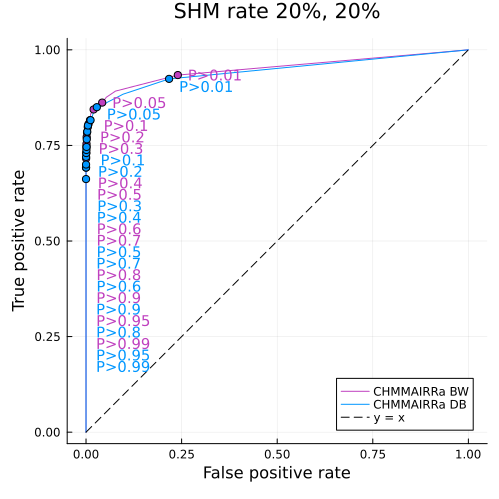

In [15]:
ROC_plots = Dict()
location = "random"
shm = 0.2
CHMMera_cutoffs = [0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
CHMMera_cutoff,reference_set_name = 0.95,"OGRDB_human_one_allele_per_gene"
p = calculate_plot_CHMMAIRRa_ROC(test_sets, location, reference_sets, reference_set_name, default_prior_probability, shm, shm; padding = 0.03, CHMMera_cutoffs = CHMMera_cutoffs, mutation_probabilities = IG_DB_mutation_probabilities)
savefig(p, joinpath(CHMMAIRRa_only_ROC_dir, "db=$(reference_set_name)_shm1,2=20_location=$(location)_prior_prob=$(default_prior_probability)_cutoff=variable.pdf"))
p

# Plot posterior probability agreement between CHMMAIRRa BW and DB (Supplementary figure?)

In [17]:
reference_set_name = "OGRDB_human_one_allele_per_gene"
location = "random"

for shm in [0.0, 0.05, 0.1, 0.2]
    @info shm
    curr_simdata = test_sets[(test_sets.shm1 .== shm) .& (test_sets.shm2 .== shm) .& (test_sets.location .== location) .& (test_sets.refset_name .== reference_set_name),:]
    srefnames, refseqs = reference_sets[reference_set_name]
    CHMMera_BW_FPRs, CHMMera_BW_TPRs, CHMMera_BW_probs, CHMMera_BW_cutoffs = CHMMera_ROC_curve(curr_simdata.sequence, curr_simdata.label, refseqs, bw = true, prior_probability = default_prior_probability, mutation_probabilities = IG_DB_mutation_probabilities)
    CHMMera_DB_FPRs, CHMMera_DB_TPRs, CHMMera_DB_probs, CHMMera_DB_cutoffs = CHMMera_ROC_curve(curr_simdata.sequence, curr_simdata.label, refseqs, bw = false, prior_probability = default_prior_probability, mutation_probabilities = IG_DB_mutation_probabilities)

    p = Plots.plot(CHMMera_BW_probs, CHMMera_DB_probs, title = "SHM rate $(Int(floor(shm * 100)))%, $(Int(floor(shm * 100)))%\nPrior probability $(round(default_prior_probability * 100, digits = 3))%", xlabel = "CHMMAIRRa BW probability", ylabel = "CHMMAIRRa DB probability", size = (500, 500), seriestype = :scatter, color = [l ? :red : :blue for l in curr_simdata.label], label = [l ? "chimeric" : "nonchimeric" for l in curr_simdata.label], alpha = 0.1, markerstrokewidth = 0.0)
    savefig(p, joinpath(plots_dir, "PP_comparison_db=$(reference_set_name)_shm1,2=$(floor(shm * 100))_location=$(location)_prior_prob=$(default_prior_probability).pdf"))
end

[ Info: 0.0
GKS: String is too long in routine INQ_TEXT
[ Info: 0.05
GKS: String is too long in routine INQ_TEXT
[ Info: 0.1
GKS: String is too long in routine INQ_TEXT
[ Info: 0.2
GKS: String is too long in routine INQ_TEXT


# Plot CHMMAIRRa BW mutation rate estimation (Supplementary figure?)

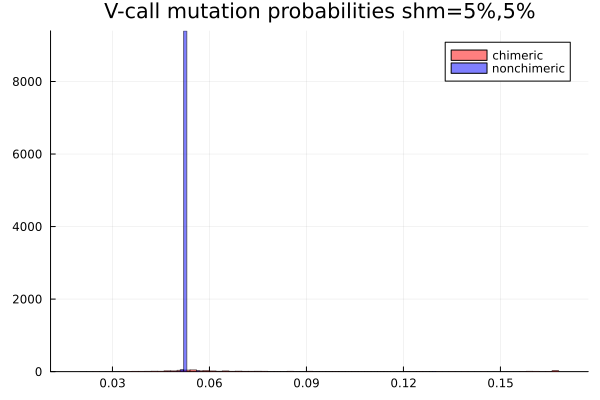

In [18]:
# set up parameters
shm1, shm2 = 0.05, 0.05
CHMMera_cutoffs = [0.999, 0.95, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
reference_set_name = "OGRDB_human_one_allele_per_gene"
location = "random"
bw = true
base_mutation_probability = 0.05

# get simulation data
curr_simdata = test_sets[(test_sets.shm1 .== shm1) .& (test_sets.shm2 .== shm2) .& (test_sets.location .== location) .& (test_sets.refset_name .== reference_set_name),:]
refnames, refseqs = reference_sets[reference_set_name]

# get reference and query sequences
references = CHMMera.as_ints.(refseqs)
queries = CHMMera.as_ints.(curr_simdata.sequence)

# get v_call_ish and v_call_ish_index
curr_simdata[!,"v_call_ish"] = [split(el, "_")[1] for el in curr_simdata[!,"sequence_id"]]
curr_simdata[!,"v_call_ish_index"] = [findfirst(x->x == el, refnames) for el in curr_simdata[!,"v_call_ish"]]
# get mutation rates
mean_mutation_probabilities = []
v_call_mutation_probabilities = []
for i in 1:length(queries)
    O = queries[i]
    mutation_probabilities = bw ? [base_mutation_probability for i in eachindex(references)] : IG_DB_mutation_probabilities
    hmm = bw ? CHMMera.ApproximateHMM(CHMMera.vovtomatrix(references), default_prior_probability) : CHMMera.FullHMM(CHMMera.vovtomatrix(references), IG_DB_mutation_probabilities, default_prior_probability)
    b = CHMMera.get_bs(hmm, O, mutation_probabilities)
    CHMMera.parameterestimation!(hmm, O, mutation_probabilities, b)
    push!(mean_mutation_probabilities, mean(mutation_probabilities))
    push!(v_call_mutation_probabilities, mutation_probabilities[curr_simdata[!,"v_call_ish_index"][i]])
end

Plots.plot(v_call_mutation_probabilities[curr_simdata.label .== 1], color = :red, seriestype = :histogram, bins = 100, alpha = 0.5, label = "chimeric", title = "V-call mutation probabilities shm=$(Int(floor(shm1 * 100)))%,$(Int(floor(shm2 * 100)))%")
Plots.plot!(v_call_mutation_probabilities[curr_simdata.label .== 0], color = :blue, seriestype = :histogram, bins = 100, alpha = 0.5, label = "nonchimeric")